In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")

/home/legolas/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/legolas/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Preparing the dataset

In [2]:
# loading the dataset
dataset = VBAIDataset('./data/bids_with_sensitive_recordings/')
#dataset_sample = VBAIDataset('./data/sample_data/')


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)
'''
train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])
'''

import random
from sklearn.model_selection import train_test_split

train_identities, temp_identities = train_test_split(all_identities, test_size=0.2, random_state=123)
val_identities, test_identities = train_test_split(temp_identities, test_size=0.5, random_state=123)


print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))


train: 142
val: 18
test: 18


### Create PyTorch dataset of all audio features given in the .pt file

In [4]:

qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))


Found 204 person/session pairs


In [5]:

class MyAudioDataset(torch.utils.data.Dataset):
    def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
        self.segment_size = segment_size
        
        # get age and airway stenosis classification for all subjects
        participant_df = dataset.load_and_pivot_questionnaire('participant')
        demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')
        
        #age_data = participant_df[['record_id', 'age']].sort_values(by='record_id').to_numpy()
        #site_data = participant_df[['record_id', 'enrollment_institution']].sort_values(by='record_id').to_numpy()
        age_data = participant_df[['record_id', 'age']].to_numpy()
        site_data = participant_df[['record_id', 'enrollment_institution']].to_numpy()
        
        gender_df = demographics_df[['record_id', 'gender_identity']]
        no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']
        new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})
        
        #gender_data = pd.concat([gender_df,new_row_df], ignore_index=True).sort_values(by='record_id').to_numpy()
        gender_data = pd.concat([gender_df,new_row_df], ignore_index=True).to_numpy()
        
        #airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        age_dict = {}
        for person_id, age in age_data:
            age_dict[str(person_id)] = float(age)

        gender_dict = {}
        for person_id, gender in gender_data:
            gender_dict[str(person_id)] = str(gender)
        
        site_dict = {}
        for person_id, site in site_data:
            site_dict[str(person_id)] = str(site)
        
        #airway_stenosis_dict = {}
        '''
        for person_id, airway_stenosis in airway_stenosis_df:
            airway_stenosis_dict[str(person_id)] = float(airway_stenosis)
        '''
        
        # get all .pt files
        self.feature_files = []
        self.age = []
        self.gender = []
        self.site = []
        
        for person_id, session_id in person_session_pairs:
            if person_id not in identities:
                continue
            
            audio_features = [str(path) for path in dataset.find_audio_features(person_id, session_id) if "Audio-Check" not in str(path)]
            self.feature_files += audio_features
            self.age += [age_dict[person_id]]*len(audio_features)
            self.gender += [gender_dict[person_id]]*len(audio_features)
            self.site += [site_dict[person_id]]*len(audio_features)
        
        #print(len(self.feature_files), len(self.age), len(self.gender), len(self.site))
        assert len(self.feature_files)==len(self.age)==len(self.gender)==len(self.site)
        
        
    def __len__(self):
        return len(self.feature_files)
        
    def __getitem__(self, idx):
        
        feature = torch.load(self.feature_files[idx])
        opensmile_feature = feature['opensmile']
        age = self.age[idx]
        gender = self.gender[idx]
        site = self.site[idx]
        
        return opensmile_feature, age, gender, site


In [6]:
#train_dataset = MyAudioDataset(train_identities, dataset, person_session_pairs)
#val_dataset = MyAudioDataset(val_identities, dataset, person_session_pairs)
#test_dataset = MyAudioDataset(test_identities, dataset, person_session_pairs)

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

print("Lenght of full dataset : " , len(full_dataset))


Lenght of full dataset :  6019


# Now let's do the visualization of data!!!

### Preparing the data for the visualization functions

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

audio_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

# Extract opensmile features, age, gender, and site
opensmile_features = []
ages = []
genders = []
sites = []

for i in range(len(audio_dataset)):
    opensmile_feature, age, gender, site = audio_dataset[i]
    opensmile_features.append(opensmile_feature.squeeze())
    ages.append(age)
    genders.append(gender)
    sites.append(site)

# Convert to DataFrame
opensmile_df = pd.DataFrame(opensmile_features)
opensmile_df['age'] = ages
opensmile_df['gender'] = genders
opensmile_df['site'] = sites

# Standardize the opensmile features
feature_columns = opensmile_df.columns[:-3]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(opensmile_df[feature_columns])



#### PCA

In [8]:

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:2], columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)


##### PCA 2D scatter plot colored by gender

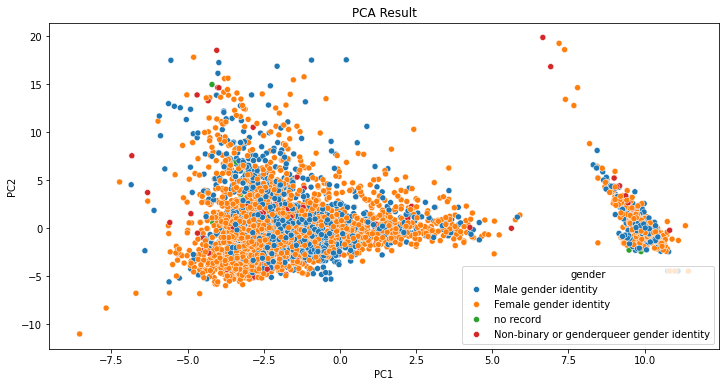

In [9]:

plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='gender', data=pca_df)
plt.title('PCA Result')
plt.show()

##### PCA 2D scatter plot colored by age

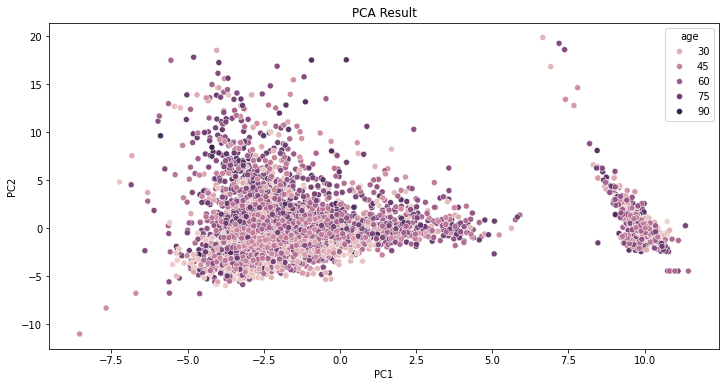

In [10]:
# Plot PCA result
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='age', data=pca_df)
plt.title('PCA Result')
plt.show()

##### PCA 3D scatter plot colored by gender

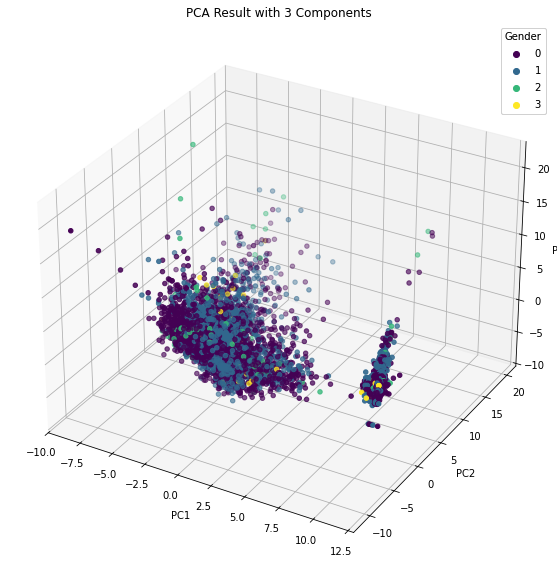

In [11]:

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:3], columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['gender'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Gender")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()



##### PCA 3D scatter plot colored by age

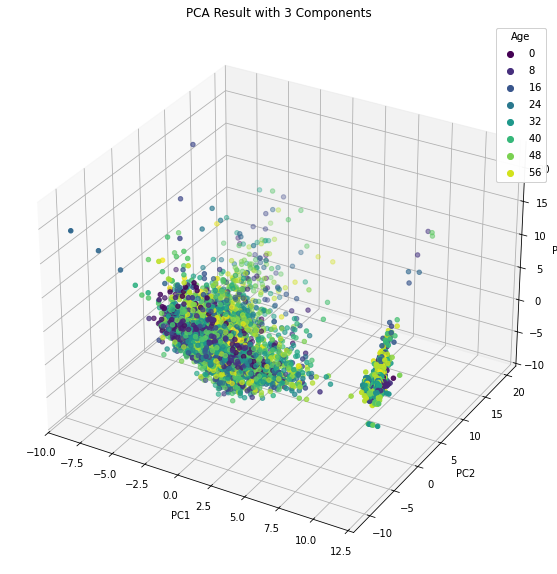

In [12]:

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()

#### t-SNE

In [13]:
# Perform t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_features)

#prepare t-SNE result for 2D scatter plot
tsne_df = pd.DataFrame(tsne_result[:,:2], columns=['TSNE1', 'TSNE2'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)



##### t-SNE 2D scatter plot colored by gender

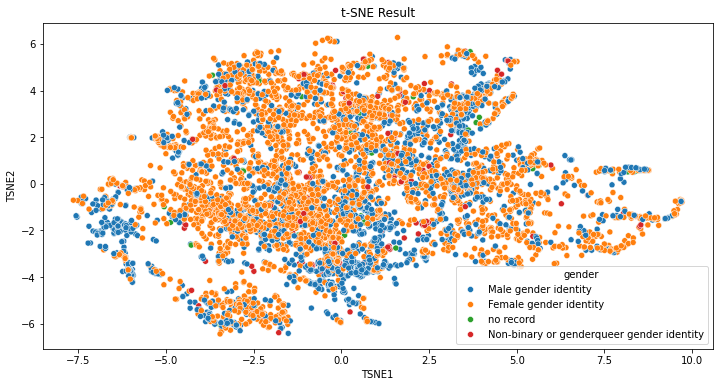

In [14]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df)
plt.title('t-SNE Result')
plt.show()

##### t-SNE 3D scatter plot colored by age

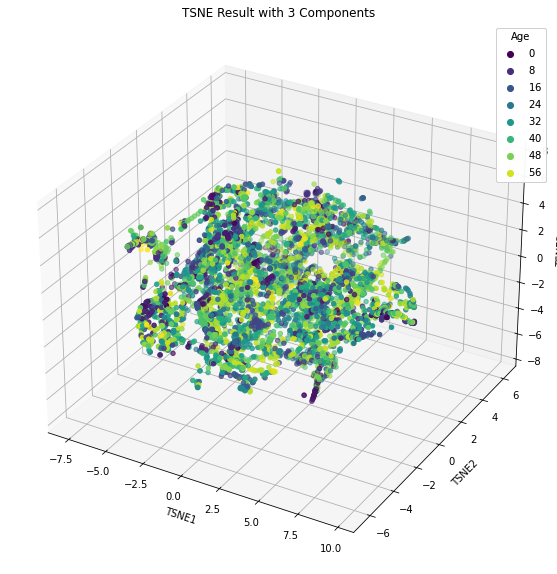

In [15]:

#prepare the data for plotting 2D scatter plot of PCA features
tsne_df = pd.DataFrame(tsne_result[:,:3], columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)

#Plot TSNE 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], c=tsne_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE Result with 3 Components')
plt.show()

#### Correlation heatmap

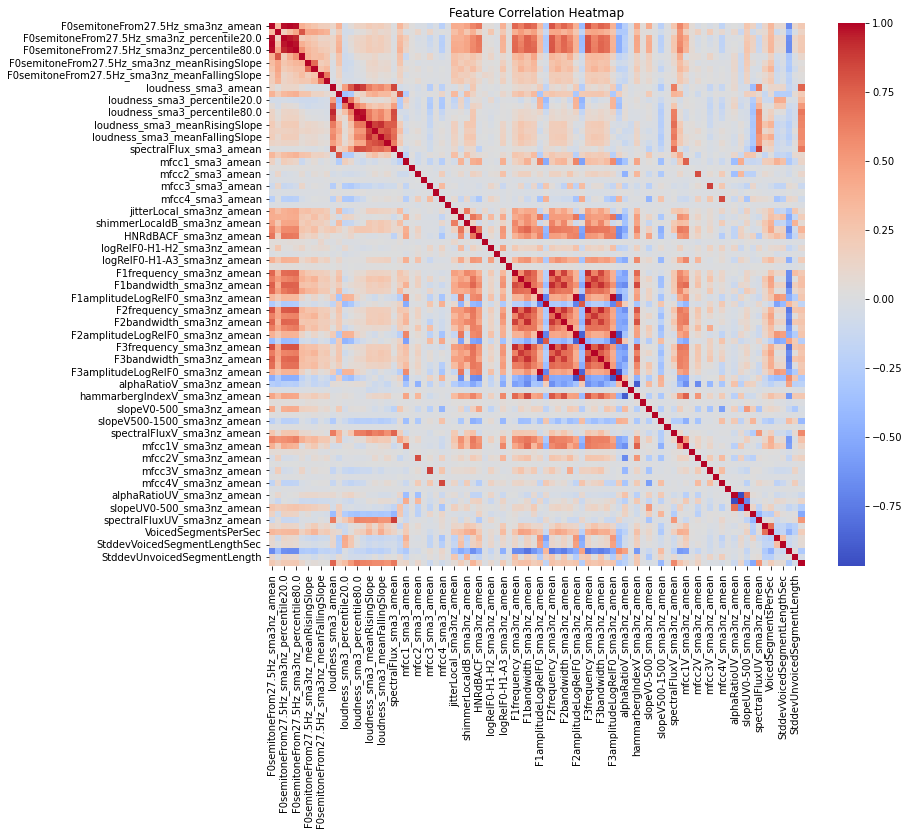

In [16]:
# Correlation Heatmap
corr_matrix = pd.DataFrame(scaled_features, columns=feature_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Test cells (ignore those)

In [ ]:
print(type(x['opensmile']['equivalentSoundLevel_dBp']))
print(type(x['opensmile']))
print(x['opensmile']['equivalentSoundLevel_dBp'].shape)
print(x['opensmile'].shape)

In [ ]:

x = torch.load('./data/sample_data/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c/ses-CC0EE711-2FC3-43D5-B7FF-21424F748985/audio/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c_ses-CC0EE711-2FC3-43D5-B7FF-21424F748985_Diadochokinesis_rec-Diadochokinesis-Pataka.pt')

x.keys()

In [17]:
print(len(list(x['opensmile'].columns)))

NameError: name 'x' is not defined

In [ ]:
for ftr in x['opensmile']:
    print(type(x['opensmile'][ftr]))

In [ ]:
print(x['opensmile'].shape, type(x['opensmile']))
for ftr in x['opensmile']:
    print(type(ftr), ftr)

In [ ]:
qs = dataset_sample.load_questionnaires('recordingschema')

print(len(qs))
#print(qs[0].json(indent=2))

In [ ]:
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema')
print(demographics_df.shape)
#print(demographics_df.columns)
demographics_df_uniq = demographics_df.drop_duplicates(subset='record_id', keep='first')
print(demographics_df_uniq.shape)

#print("Duplicates : ", demographics_df[demographics_df.duplicated(subset='record_id')]['record_id'].to_list())

participant_df = dataset.load_and_pivot_questionnaire('participant')

ids_in_participant_not_demographic = participant_df.set_index('record_id').index.difference(demographics_df_uniq.set_index('record_id').index)

#print(ids_in_participant_not_demographic.to_list())

#duplicate_demographics_record = ['01401050-e9dd-486e-b0d4-0001ee7f861d', 'd554cc1a-efe5-4b7a-a77b-f5abca8846bd', '771fb46d-e94a-4129-ab3d-32cadf92c6f0']
#no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']

#df = pd.read_csv('/home/mithrandir/Documents/Summer school/data/demographics.csv')

#print(df.shape)
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')[['record_id', 'gender_identity']]
print(demographics_df.shape)
row1 = {'record_id': no_demographics_record[0], 'gender_identity': 'no record'}
row1 = {'record_id': no_demographics_record[1], 'gender_identity': 'no record'}

new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})

demographics_df = pd.concat([demographics_df,new_row_df], ignore_index=True).sort_values(by='record_id').to_numpy()
print(demographics_df.shape)
